# **Assignment 1: Step count**
#### Yuna Watanabe

## **Data structure**
The data used are included in `./data` repository. In this folder, multiple folders are included, each representing one session/scenario. In this work, I used the following scenarios to tune and test the algorithm.

- **phone_in_hand**: Phone was held in hand in front of chest.
- **phone_in_hand_slow**: Phone was held in hand in front of chest, but walked a bit slowly.
- **phone_in_hand_down**: Phone was held in hand, and the hand was down as we usually walk.
- **phone_in_right_pocket**: Phone was in right pocket of pants.
- **phone_in_backpack**: Phone was in a backpack.
- **phone_in_hand_up_down**: Phone was held in hand but the hand was sometimes moved. This is a mixture of the phone_in_hand condition and the phone_in_hand_down condition.

For convenience, the total number of steps were 100 steps in all conditions. I used this number as ground truth and compared the performance of the algorithm with the default real-time detection algorithm on phone.

## **Set parameters**

For visualization purposes, set ground truth step counts here.

In [1]:
ground_truth_steps = [100, 100, 100, 100, 100, 100]

In [2]:
# Set sampling frequency
SAMPLING_RATE = 100

## **Import libraries**

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import os
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt, freqz, find_peaks

import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

## **Visualize data**

In [4]:
# Get folder names
data_dir = 'data/'
folders = os.listdir(data_dir)
folders

['phone_in_hand_down',
 'phone_in_hand_up_down',
 'phone_in_hand',
 'phone_in_hand_slow',
 'phone_in_backpack',
 'phone_in_right_pocket']

In [5]:
# Read accelerometer data
acc_list = []
for folder in folders:
    acc = pd.read_csv(data_dir + folder + '/acce.csv', header = None, names = ['Timestamp', 'acc_x', 'acc_y', 'acc_z'])
    acc['Timestamp'] = pd.to_datetime(acc['Timestamp'], unit = 'ns')
    acc_list.append(acc)
acc_list[0]

,Timestamp,acc_x,acc_y,acc_z
0,2024-10-01 16:55:55.727354112,-6.600674,6.566245,-3.113675
1,2024-10-01 16:55:55.738167040,-6.583460,6.574029,-3.002756
2,2024-10-01 16:55:55.747318016,-6.666836,6.520740,-2.962639
3,2024-10-01 16:55:55.757373952,-6.799610,6.452781,-2.794688
4,2024-10-01 16:55:55.767375872,-6.952742,6.378536,-2.598746
...,...,...,...,...
6306,2024-10-01 16:56:58.915195904,-3.482059,-0.766556,-9.722731
6307,2024-10-01 16:56:58.925190912,-3.609294,-0.732726,-9.533974
6308,2024-10-01 16:56:58.935203072,-3.418441,-0.538879,-9.523346
6309,2024-10-01 16:56:58.945209088,-3.296146,-0.813708,-9.918824


In [6]:
# Read the detected number of steps using the step counter on phone
steps_count = []
for folder in folders:
    step_df = pd.read_csv(data_dir + folder + '/step.csv', names = ['Timestamp', 'Step count', 'Manitude'])
    steps_count.append(int(step_df.loc[len(step_df) - 1, 'Step count']))
steps_count

[100, 91, 100, 119, 101, 99]

In [7]:
# Check recording length
acc = acc_list[0]
len_sec = (acc.loc[len(acc)-1, 'Timestamp'] - acc.loc[0, 'Timestamp']).total_seconds()
print(f'{len_sec} sec')

63.227919 sec


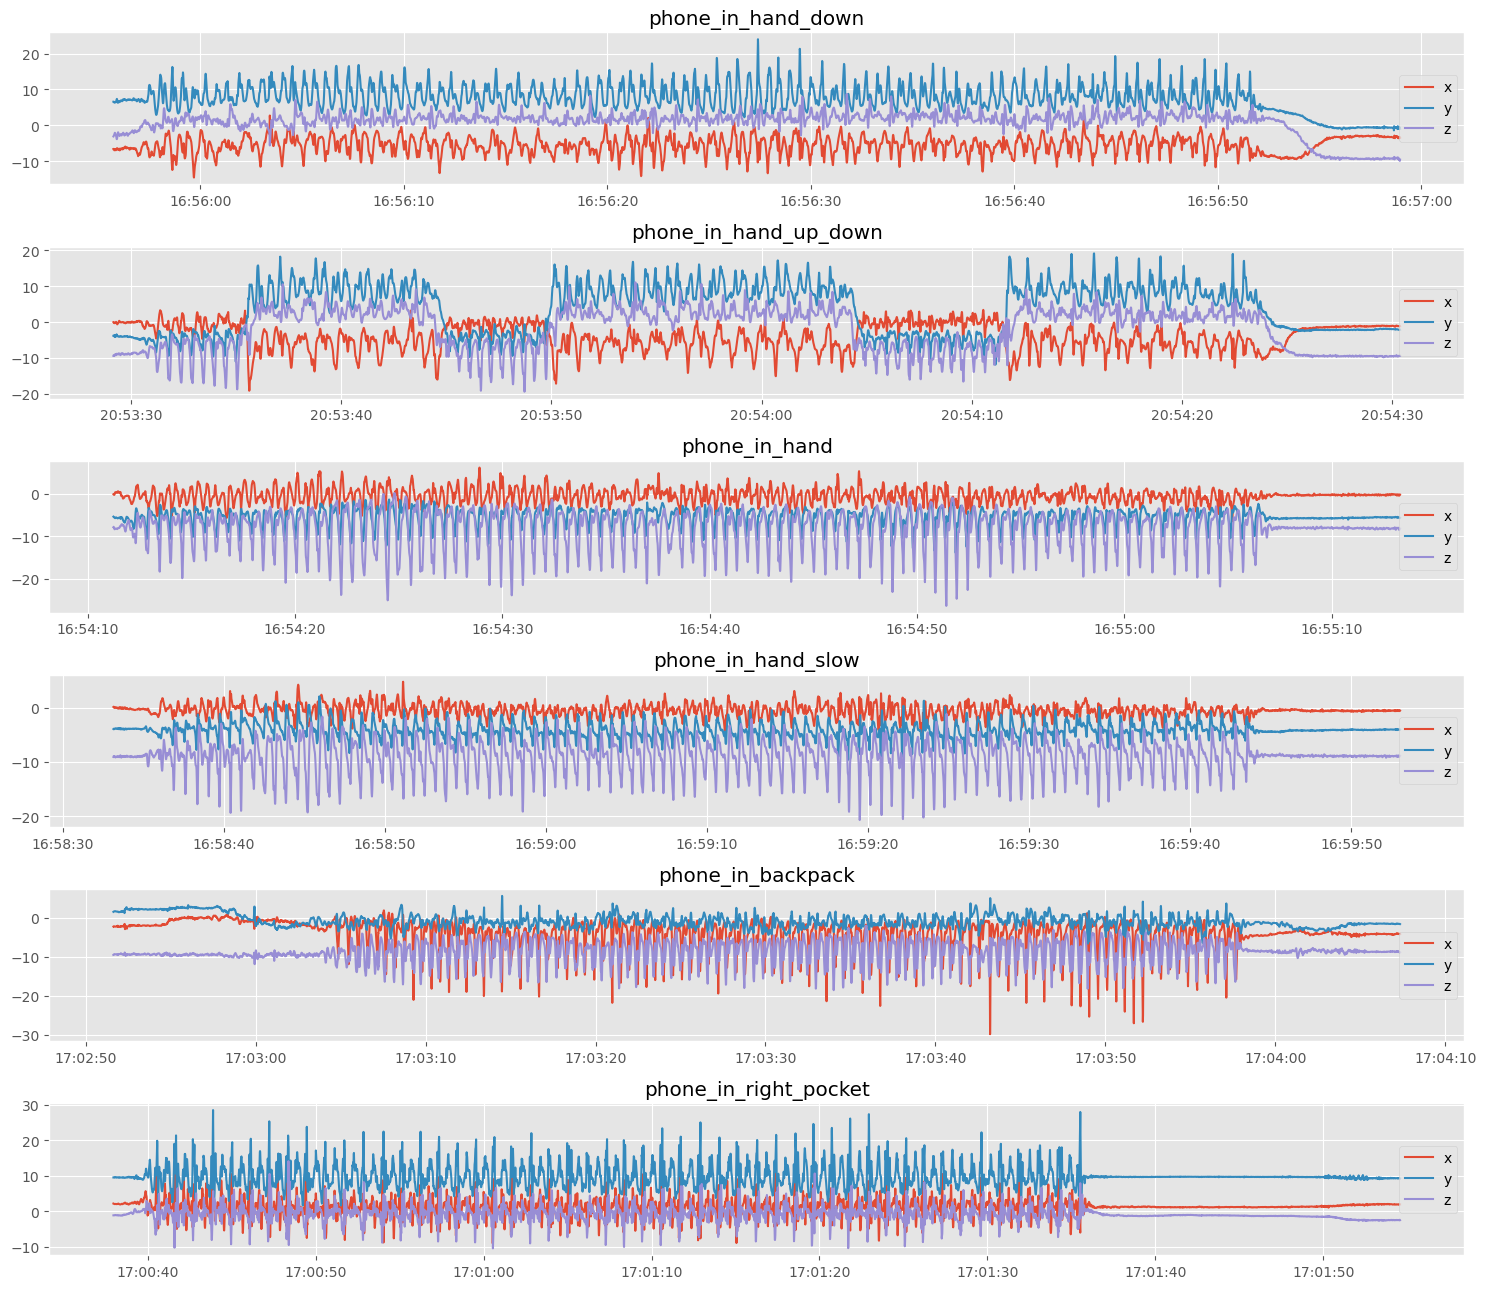

In [8]:
# Plot raw accelerometer data
fig, axes = plt.subplots(ncols=1, nrows=len(acc_list), figsize = (15, 13))
for i in range(len(acc_list)):
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['acc_x'], label = 'x')
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['acc_y'], label = 'y')
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['acc_z'], label = 'z')
    axes[i].legend(loc = 'right')
    axes[i].set_title(folders[i])
plt.tight_layout()

## **Calculate magnitude**

Here, convert the raw accelerometer data into magnitude.

In [9]:
def calculate_magnitude(row):
    '''
    A function to calculate the magnitude of the acceleration vector.
    '''
    return np.sqrt(row['acc_x']**2 + row['acc_y']**2 + row['acc_z']**2)

# Apply the function to all session data
for acc in acc_list:
    acc['magnitude'] = acc.apply(calculate_magnitude, axis = 1)
acc_list[0]

,Timestamp,acc_x,acc_y,acc_z,magnitude
0,2024-10-01 16:55:55.727354112,-6.600674,6.566245,-3.113675,9.817303
1,2024-10-01 16:55:55.738167040,-6.583460,6.574029,-3.002756,9.776316
2,2024-10-01 16:55:55.747318016,-6.666836,6.520740,-2.962639,9.784885
3,2024-10-01 16:55:55.757373952,-6.799610,6.452781,-2.794688,9.781787
4,2024-10-01 16:55:55.767375872,-6.952742,6.378536,-2.598746,9.786717
...,...,...,...,...,...
6306,2024-10-01 16:56:58.915195904,-3.482059,-0.766556,-9.722731,10.355860
6307,2024-10-01 16:56:58.925190912,-3.609294,-0.732726,-9.533974,10.220594
6308,2024-10-01 16:56:58.935203072,-3.418441,-0.538879,-9.523346,10.132633
6309,2024-10-01 16:56:58.945209088,-3.296146,-0.813708,-9.918824,10.483786


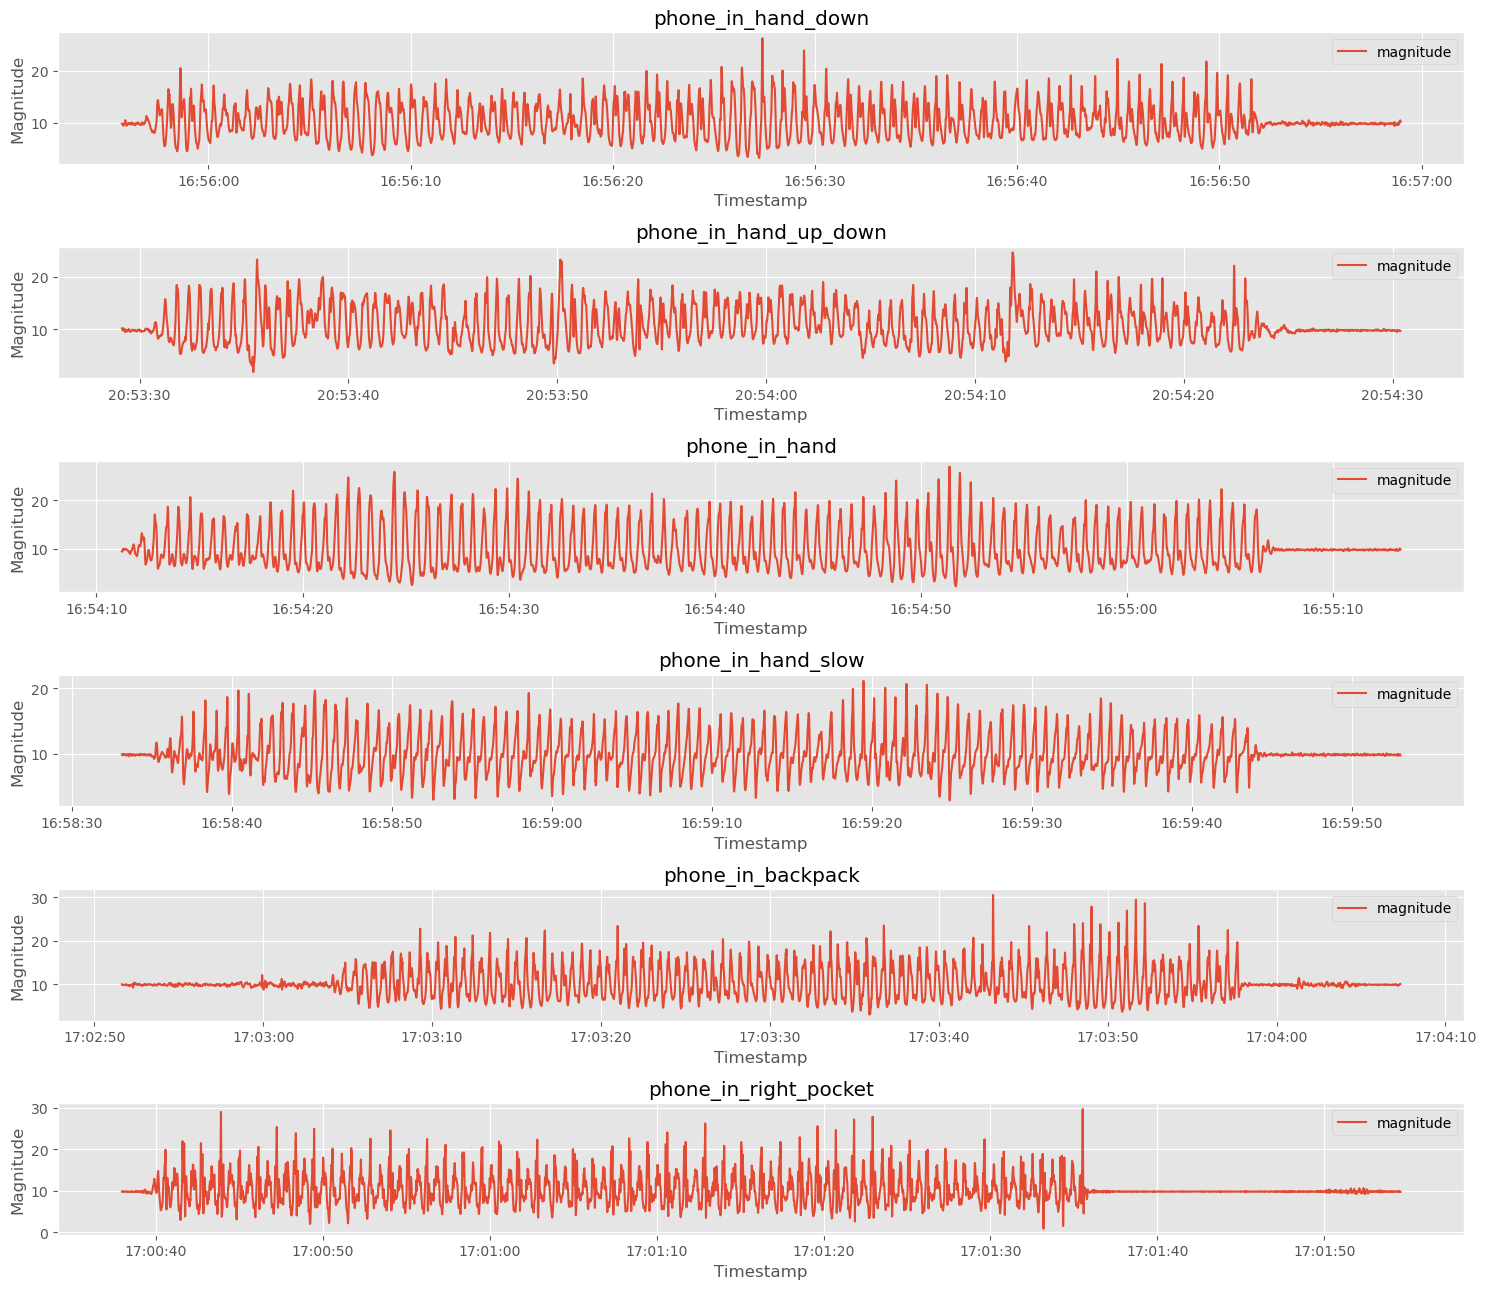

In [10]:
# Plot the calculated magnitude data
fig, axes = plt.subplots(ncols=1, nrows=len(acc_list), figsize = (15, 13))
for i in range(len(acc_list)):
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['magnitude'], label = 'magnitude')
    axes[i].set_title(folders[i])
    axes[i].legend(loc = 'upper right')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel('Magnitude')
plt.tight_layout()

The calculated magnitude looks relatively clean but still contains noises. Especially noises in higher frequency are prominent. Therefore, I analyzed the frequency of the signals and applied frequency-domain noise removal.

## **Frequency analysis**

In this section, conduct fast fourier transform and decompose the signals into different frequency components. Then, inspect the FFT spectrum of the magnitude data and identify appropriate frequency range to filter out.

In [11]:
# Take FFT
f_list = []
fft_list = []

for acc in acc_list:
    N = len(acc)
    f = rfftfreq(N, 1/SAMPLING_RATE)
    f_list.append(f)
    fft = rfft(acc['magnitude'].values, N)
    fft_list.append(fft)

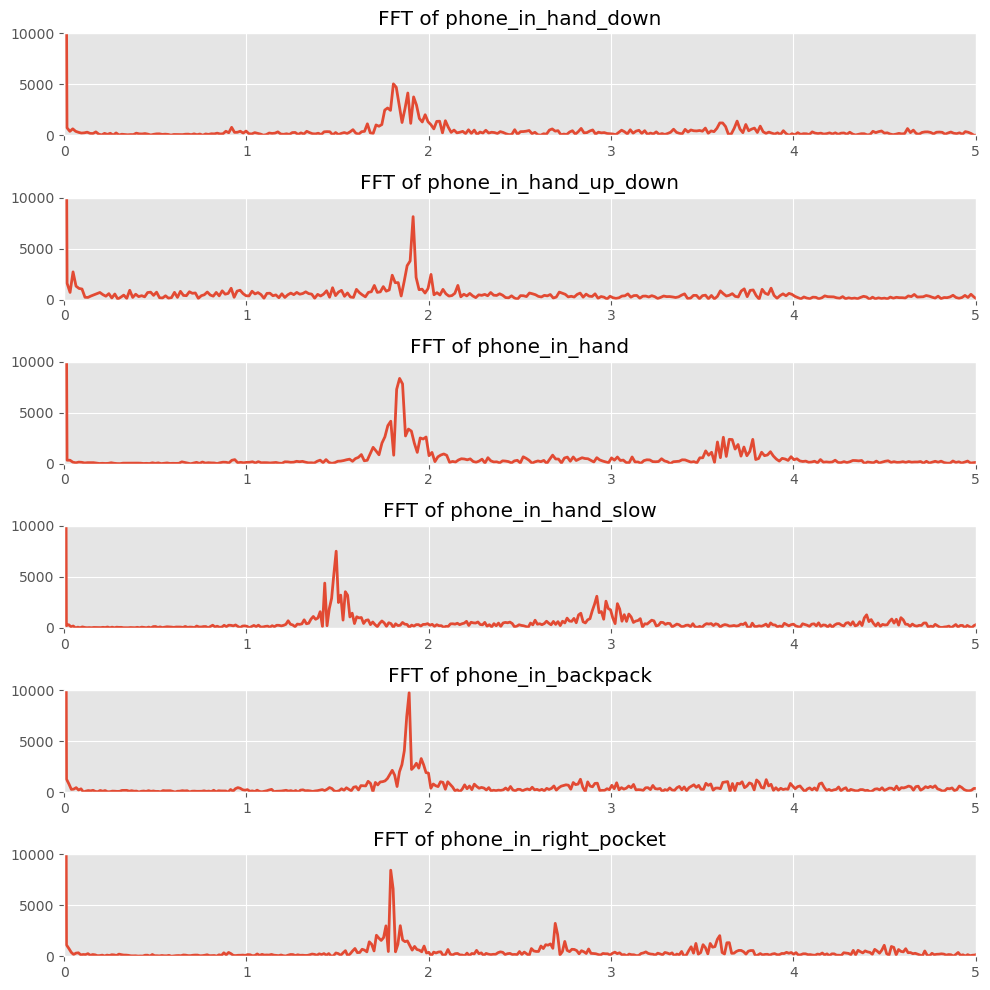

In [12]:
# Plot FFT spectrum
fig, axes = plt.subplots(nrows=len(acc_list), ncols=1, figsize = (10, 10))

for i, Y in enumerate(fft_list):
    ax = axes[i]
    ax.plot(f_list[i], np.abs(Y), linewidth=2)
    ax.set_xlim(0, SAMPLING_RATE/2)
    ax.set_title('FFT of ' + folders[i])
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 10000)
plt.tight_layout()
plt.show()

Looking at the FFT spectrum, there are major peaks in 1.5-2 Hz. Some sessions also contain peaks around 2.5-4Hz. Considering the walking speed, step information should be in 1-2.5 Hz. In the next section, I will filter out other frequency ranges to extract relevant information.

## **Filter the signal (frequency-domain)**

Here, I applied a bandpass filter to filter out frequencies ~1Hz and 2.5Hz~. Although I could have limited to 1.2-2Hz in the case above, I adopted 1-2.5Hz to accommodate different walking speed.

In [13]:
# Set the lowest and highest frequency to pass
low = 1
high = 2.5

# calculate the Nyquist frequency
nyq = 0.5 * SAMPLING_RATE

# set order of the filter
order = 5

# Create filters 
b_band, a_band = butter(order, [low/nyq, high/nyq], btype='bandpass') # Bandpass filter¥

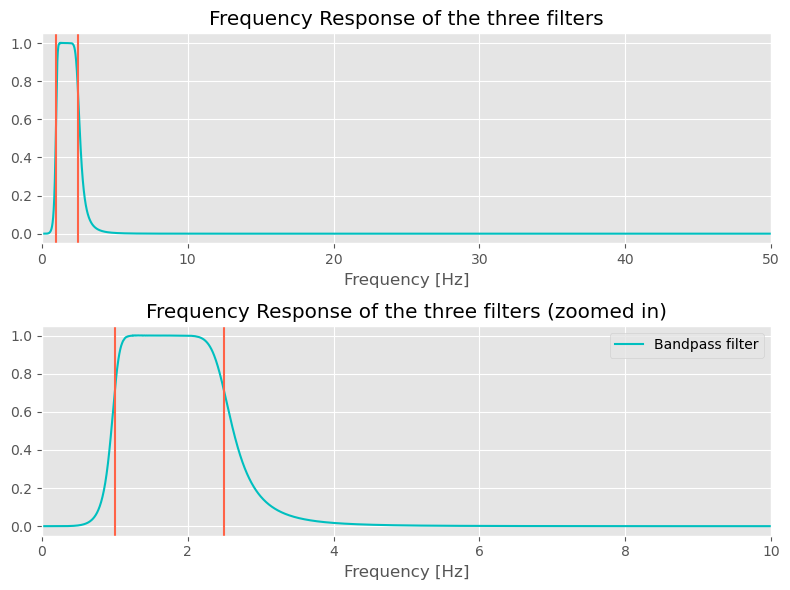

In [14]:
# Frequency response graph
w_band, h_band = freqz(b_band, a_band, worN=8000)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize = (8, 6))

axes[0].plot(0.5 * SAMPLING_RATE * w_band / np.pi, np.abs(h_band), 'c', label='Bandpass filter')
axes[0].axvline(low, color = 'tomato')
axes[0].axvline(high, color = 'tomato')
axes[0].set_xlim(0, 0.5 * SAMPLING_RATE)

axes[1].plot(0.5 * SAMPLING_RATE * w_band / np.pi, np.abs(h_band), 'c', label='Bandpass filter')
axes[1].axvline(low, color = 'tomato')
axes[1].axvline(high, color = 'tomato')
axes[1].set_xlim(0, 10)

axes[0].set_title('Frequency Response of the three filters')
axes[0].set_xlabel('Frequency [Hz]')
axes[1].set_title('Frequency Response of the three filters (zoomed in)')
axes[1].set_xlabel('Frequency [Hz]')
plt.tight_layout()
plt.legend()
plt.show()

The order = 5 looks reasonable, effectively filtering out ~1Hz and 2.5Hz~, and mainly keeping 1-2Hz.

In [15]:
# Filter the data
for acc in acc_list:
    acc['Bandpass filtered'] = filtfilt(b_band, a_band, acc.magnitude)

Then, I re-checked the frequency components after filtering.

In [16]:
# Take FFT
f_list = []
fft_list = []

for acc in acc_list:
    N = len(acc)
    f = rfftfreq(N, 1/SAMPLING_RATE)
    f_list.append(f)
    fft = rfft(acc['Bandpass filtered'].values, N)
    fft_list.append(fft)

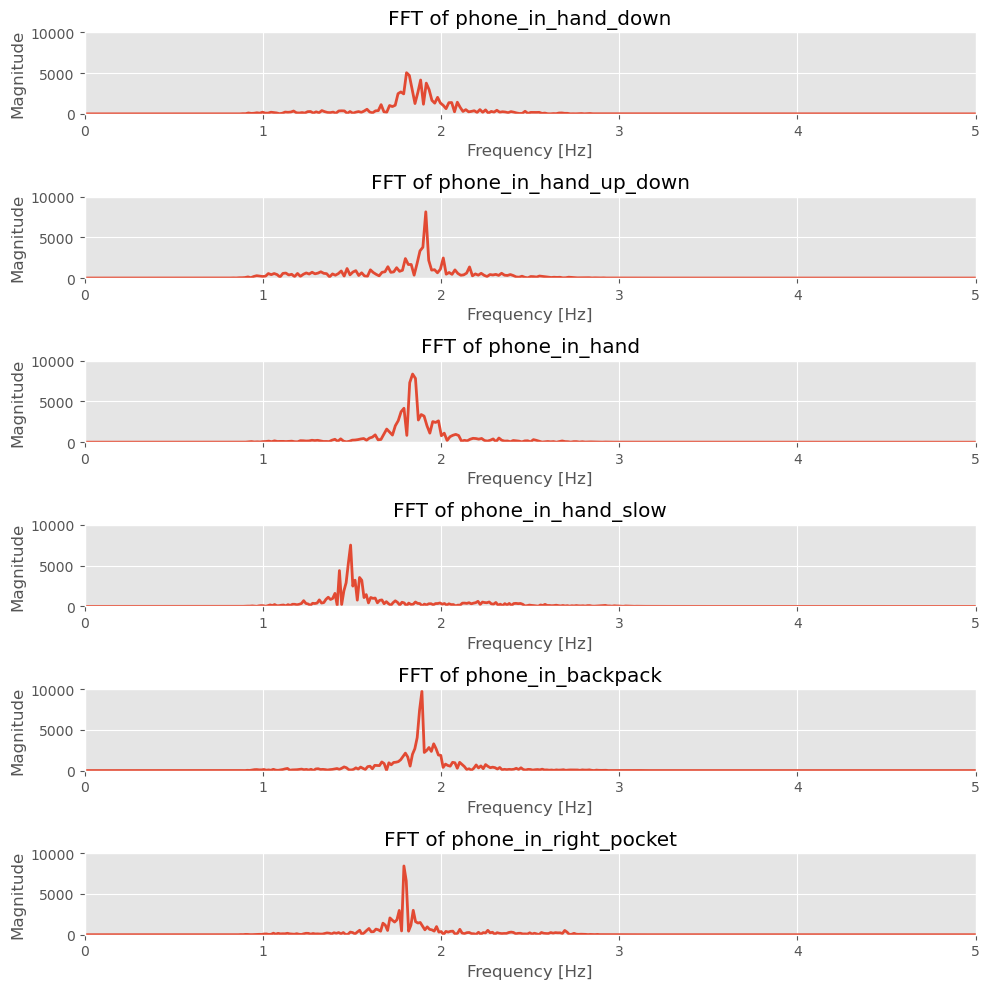

In [17]:
# Plot FFT spectrum
fig, axes = plt.subplots(nrows=len(acc_list), ncols=1, figsize = (10, 10))

for i, Y in enumerate(fft_list):
    ax = axes[i]
    ax.plot(f_list[i], np.abs(Y), linewidth=2)
    ax.set_xlim(0, SAMPLING_RATE/2)
    ax.set_title('FFT of ' + folders[i])
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 10000)
    ax.set_xlabel('Frequency [Hz]')
    ax.set_ylabel('Magnitude')
plt.tight_layout()
plt.show()

I can confirm that large noise peaks are removed from the signal.

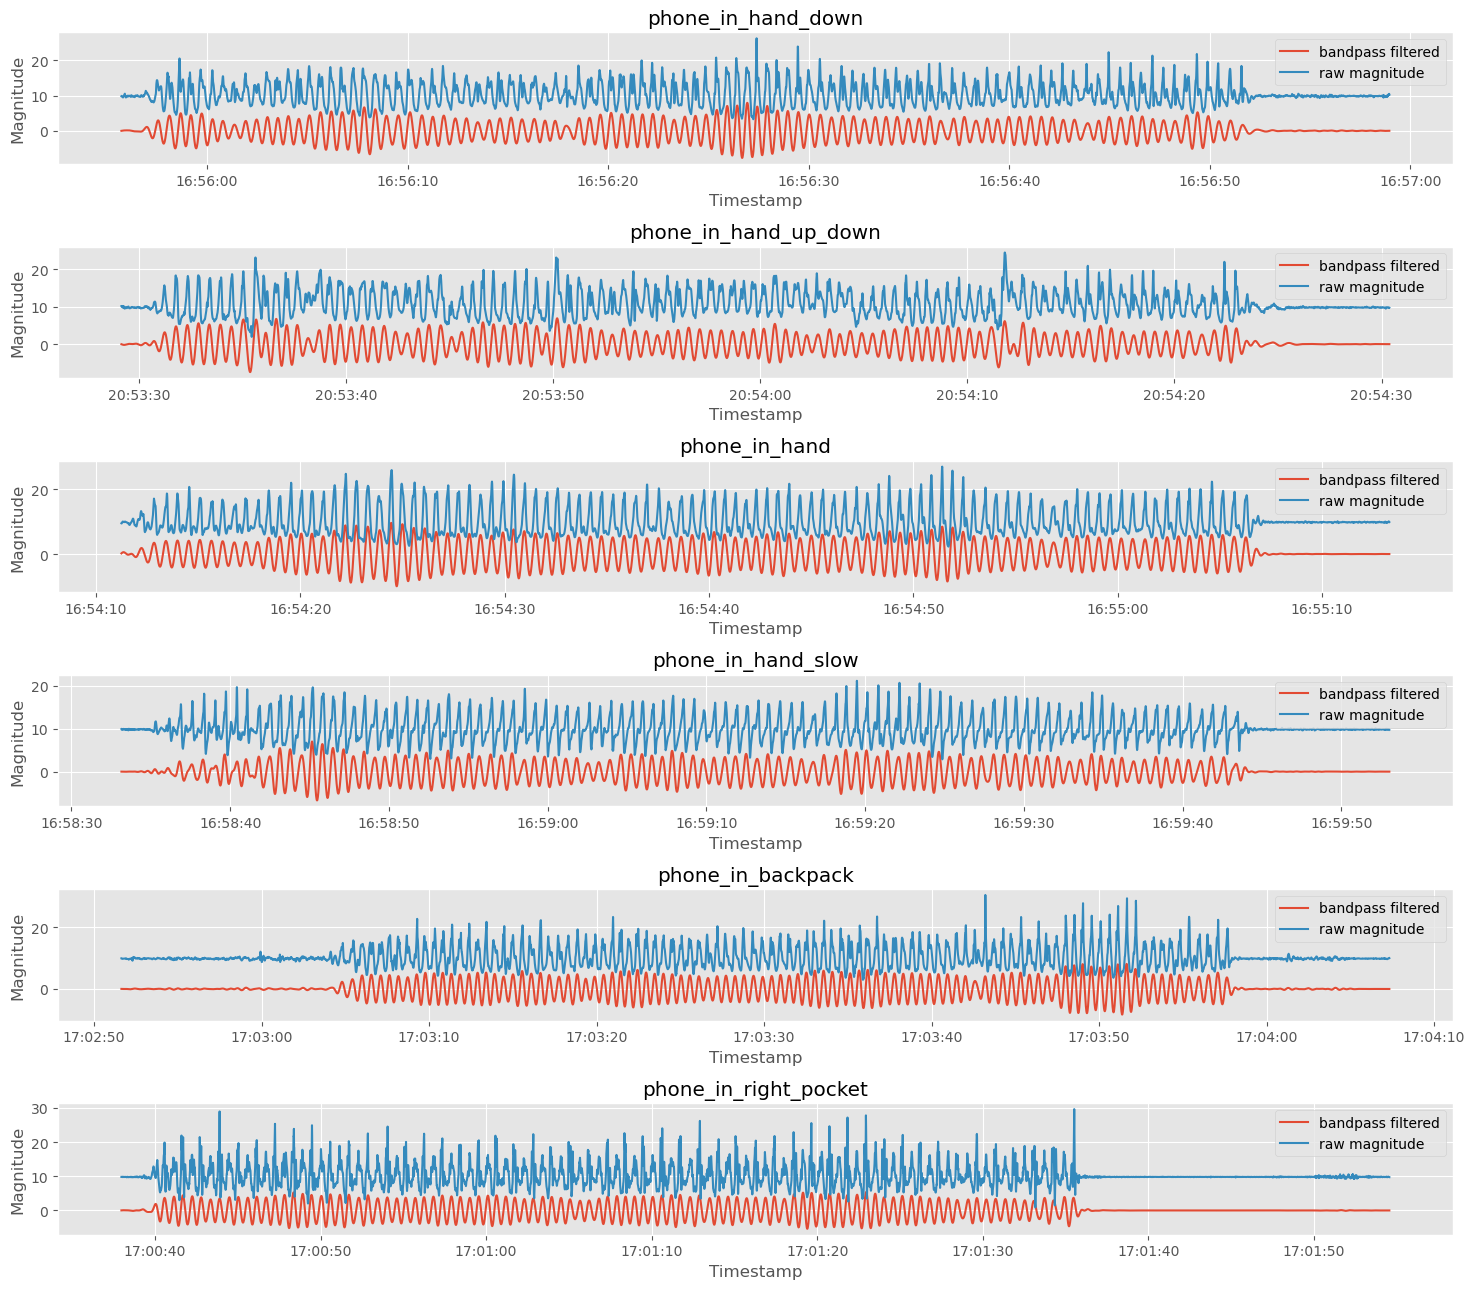

In [18]:
# Plot the filtered data along with raw data
fig, axes = plt.subplots(ncols=1, nrows=len(acc_list), figsize = (15, 13))
for i in range(len(acc_list)):
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['Bandpass filtered'], label = 'bandpass filtered')
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['magnitude'], label = 'raw magnitude')
    axes[i].set_title(folders[i])
    axes[i].legend(loc = 'upper right')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel('Magnitude')
plt.tight_layout()

The filtered signals look much cleaner than the original signals but still maintain step-related frequency components. 

## **Peak detection**

I applied peak detection algorithm in scipy library (`find_peaks()`) and detected peaks in the filtered signals. This function has several parameters:
- `distance`: This parameter sets a criterion for the vertical distance to its neighboring samples. Because steps are not likely to be detected within 0.3 seconds, I set this parameter as `0.3 * SAMPLING_RATE`

- `prominence`: This parameter sets a criterion for the elevation of a peak relative to the surrounding terrain. Here, I identified the signal range by calculating the difference between the maximum and minimum signal values and set prominence as `signal_range * 0.1`. This way, I tried to estimate the maximum wave height and accept peaks that have more than 10% of the maximum height as valid peaks.

In [19]:
# Detect peaks
n_peaks = []
for acc in acc_list:
    signal_range = acc['Bandpass filtered'].max() - acc['Bandpass filtered'].min()
    peaks = find_peaks(acc['Bandpass filtered'], distance = 0.3 * SAMPLING_RATE, prominence = signal_range * 0.1)
    n_peaks.append(len(peaks[0]))
    acc['peak'] = 0
    acc.loc[acc.index.isin(peaks[0]), 'peak'] = 1

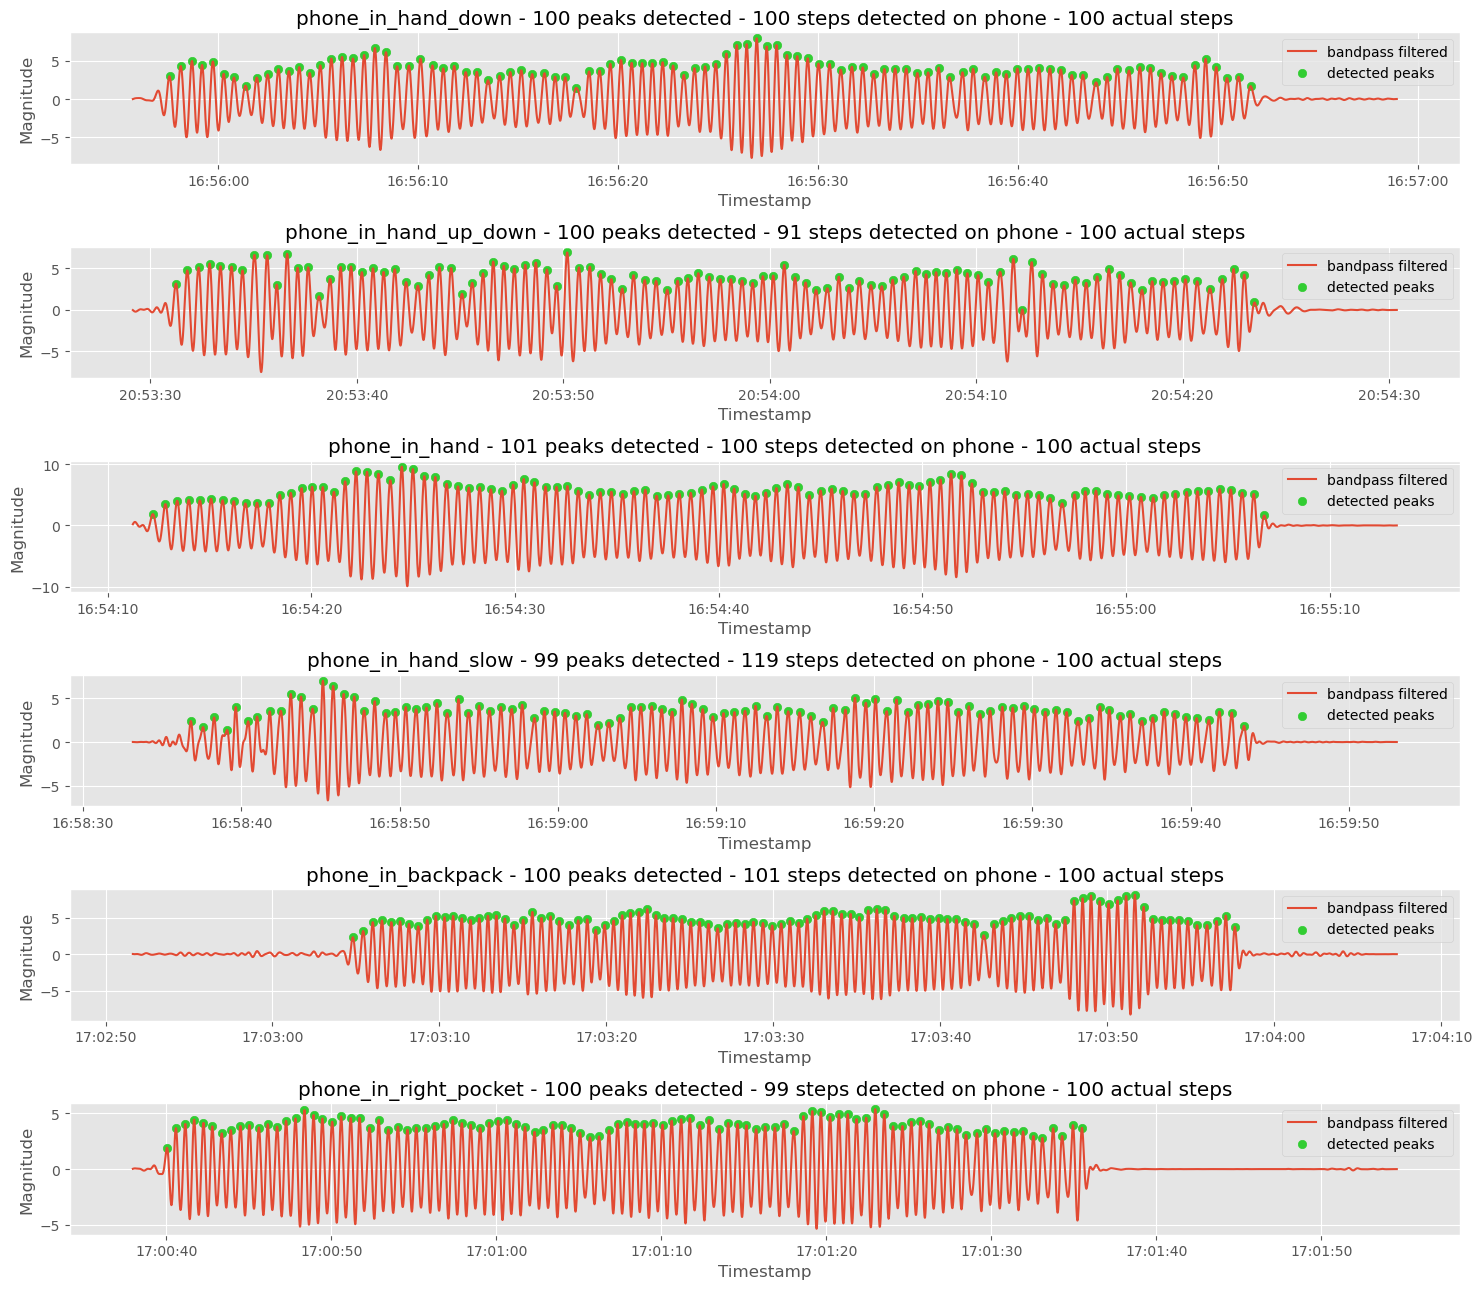

In [20]:
# Plot detected peaks
fig, axes = plt.subplots(ncols=1, nrows=len(acc_list), figsize = (15, 13))
for i in range(len(acc_list)):
    axes[i].plot(acc_list[i]['Timestamp'], acc_list[i]['Bandpass filtered'], label = 'bandpass filtered')
    acc_peaks = acc_list[i].loc[acc_list[i]['peak'] == 1]
    axes[i].scatter(acc_peaks['Timestamp'], acc_peaks['Bandpass filtered'], label = 'detected peaks', color = 'limegreen')
    axes[i].set_title(f'{folders[i]} - {n_peaks[i]} peaks detected - {steps_count[i]} steps detected on phone - {ground_truth_steps[i]} actual steps')
    axes[i].legend(loc = 'upper right')
    axes[i].set_xlabel('Timestamp')
    axes[i].set_ylabel('Magnitude')
plt.tight_layout()
plt.show()

Each graph shows filtered signals and the location of detected peaks. The title of each graph shows conditions, how many peaks are detected by this algorithm, how many peaks are detected by the built-in algorithm in phone, and the ground truth step counts. Although the developed algorithm has a small amount of error in `phone_in_hand` and `phone_in_hand_slow` conditions, both deviate from the ground truth values only by 1, which is not a significant difference. Also, when comparing the default algorithm and the developed algorithm, the developed algorithm has smaller amount of error overall, especially for the `phone_in_hand_slow` and the `phone_in_hand_up_down` conditions. 